# COVID19 Data Analysis 



In [7]:
## Importing the libraries:
import os, sys

import cachetools.func

import matplotlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,7.27)})

from datetime import datetime


Below is a python class that fetches the latest COVID19 data from John Hopkins Server for any contry in the world.

In [2]:
def fix_region_name(df, pairs = [["Mainland China", "China"]]):
  # fix region names
  for p in pairs:
    df['Country/Region'] = df['Country/Region'].str.replace(p[0],p[1])

  return df

#-----
def merge_df_data(df1,df2):
  return pd.merge(df1, df2,how='left' ,on=['Province/State','Country/Region'])

#-----
def str_add_func(*args):      
  out = []
  for x in args:
    if isinstance(x,str):
      out.append(x)
  
  return '_'.join(out)


class covid_data():
  '''
  Python class to obtain global COVID19 data from 
  John Hopkins GIT repository. This data is updated daily, 
  and the most upto date information available on the web.  
  '''
  def __init__(self,**kwargs):

    #
    nrow = kwargs.get('nrow',None)
    self.confirmed, self.dead, self.recovered = self.get_csseg_data(nrow=nrow)

  @staticmethod
  def create_ts(df):
    ts=df
    columns = ts['region']
    ts=ts.drop(['Province/State', 
                'Country/Region',
                'Lat', 
                'Long',
                'Population'], 
               axis=1).set_index('region').T    

    ts.columns = columns 
    ts=ts.fillna(0)
    #
    ts.index.name = 'Date'
    return ts

  def search_agg(self, name,col='Country/Region',ts=True):
    
    if not isinstance(name,list):
      name = [name]

    out = {}
    for k,v in {'confirmed':self.confirmed,
                'dead':self.dead,
                'recovered':self.recovered}.items():

      #pd.columns(columns=)
      df_list= []     
      for n in name:
        df = v[v[col]==n].set_index(col).filter(regex='/20')
        df_list.append(df.sum(axis=0))

      df = pd.concat(df_list,axis=1, sort=False)
      df.columns = name
      out[k] = df

      # if ts:                
      #   out[k] = self.create_ts(df)
      # else:
      #   out[k] = df.T

    return out

  def search(self, name,col='Country/Region',ts=True):
    
    if not isinstance(name,list):
      name = [name]

    out = {}
    for k,v in {'confirmed':self.confirmed,
                'dead':self.dead,
                'recovered':self.recovered}.items():
      if ts:                
        out[k] = self.create_ts(v[v[col].map(lambda x: x in name)])
      else:
        out[k] = v[v[col] in name].T
    
    return out

  @cachetools.func.ttl_cache(maxsize=128, ttl=24 * 60)
  def get_csseg_data(self, nrow=None):
    
    url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master'
    path = f'{url}/csse_covid_19_data/csse_covid_19_time_series' 

    # 
    
    url = f'{path}/time_series_covid19_confirmed_global.csv'
    confirmed = fix_region_name(pd.read_csv(url, nrows=nrow, error_bad_lines=False))
    #
    url = f'{path}/time_series_covid19_deaths_global.csv'
    dead = fix_region_name(pd.read_csv(url, nrows=nrow, error_bad_lines=False))
    #
    url = f'{path}/time_series_covid19_recovered_global.csv'
    
    recovered = fix_region_name(pd.read_csv(url, nrows=nrow, error_bad_lines=False))
    print(confirmed.head())
    #
    return confirmed, dead, recovered


In [29]:
'''
    Extract the data of selected countries.
'''
cd = covid_data()
countries = ['Ghana','Burkina Faso','Nigeria','Togo','Mali']
mm = cd.search_agg(countries)

for ix, ctype in enumerate(['confirmed', 'dead', 'recovered']):
  df = mm[ctype].stack().reset_index()

  df = df.rename(columns={'level_0':'date','level_1':'country',0:ctype})     
  if ix==0:
    df['date'] = pd.to_datetime(df['date'])
    dfall = df
  else:
    dfall[ctype] = df[ctype]

dfall['date'] = pd.to_datetime(dfall['date']) 
mask = (dfall['date'] > '2020-03-12') & (dfall['date'] <= datetime.today().strftime('%Y-%m-%d'))



datagroup = dfall.loc[mask].groupby('country')





  Province/State Country/Region      Lat     Long  1/22/20  1/23/20  1/24/20  \
0            NaN    Afghanistan  33.0000  65.0000        0        0        0   
1            NaN        Albania  41.1533  20.1683        0        0        0   
2            NaN        Algeria  28.0339   1.6596        0        0        0   
3            NaN        Andorra  42.5063   1.5218        0        0        0   
4            NaN         Angola -11.2027  17.8739        0        0        0   

   1/25/20  1/26/20  1/27/20  ...  6/28/20  6/29/20  6/30/20  7/1/20  7/2/20  \
0        0        0        0  ...    30967    31238    31517   31836   32022   
1        0        0        0  ...     2402     2466     2535    2580    2662   
2        0        0        0  ...    13273    13571    13907   14272   14657   
3        0        0        0  ...      855      855      855     855     855   
4        0        0        0  ...      267      276      284     291     315   

   7/3/20  7/4/20  7/5/20  7/6/20  7/7

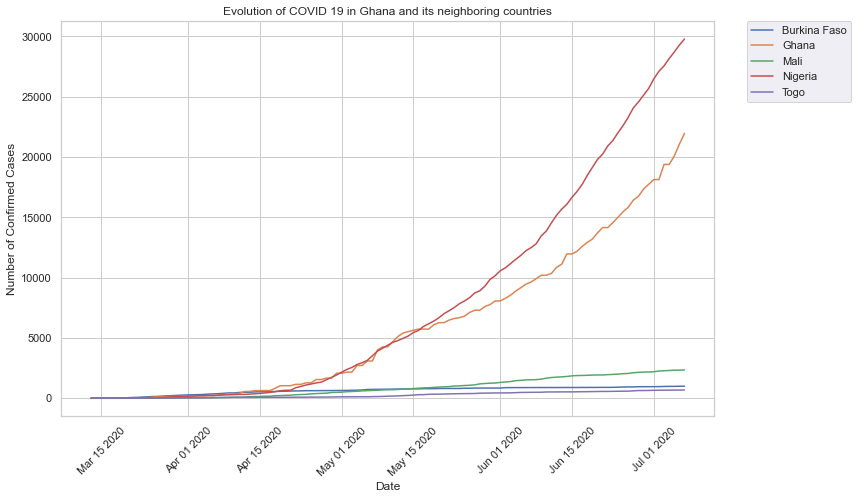

In [30]:
#Confirmed cases
for key, data in datagroup:
   
    
    with sns.axes_style('whitegrid'):
        chart4 = sns.lineplot(x=data['date'], y=data['confirmed'], label=key)

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    chart4.set_xticklabels(data['date'],rotation=45)
    chart4.xaxis.set_major_formatter(mdates.DateFormatter('%b %d %Y'))
    chart4.set_title('Evolution of COVID 19 in Ghana and its neighboring countries')
    chart4.set(xlabel='Date', ylabel='Number of Confirmed Cases')
       
    
    

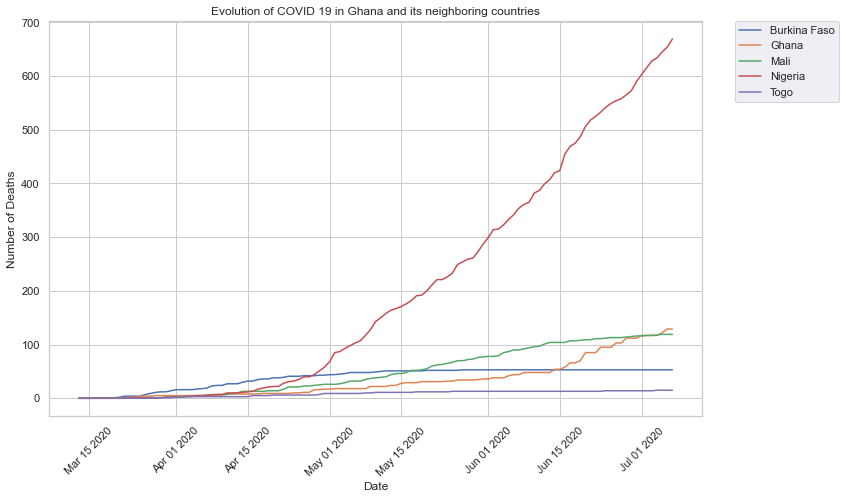

In [31]:
#Death cases
for key, data in datagroup:
    with sns.axes_style('whitegrid'):
        chart5 = sns.lineplot(x=data['date'], y=data['dead'], label=key)
        
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    chart5.set_xticklabels(data['date'],rotation=45)
    chart5.xaxis.set_major_formatter(mdates.DateFormatter('%b %d %Y'))
    chart5.set_title('Evolution of COVID 19 in Ghana and its neighboring countries')
    chart5.set(xlabel='Date', ylabel='Number of Deaths')

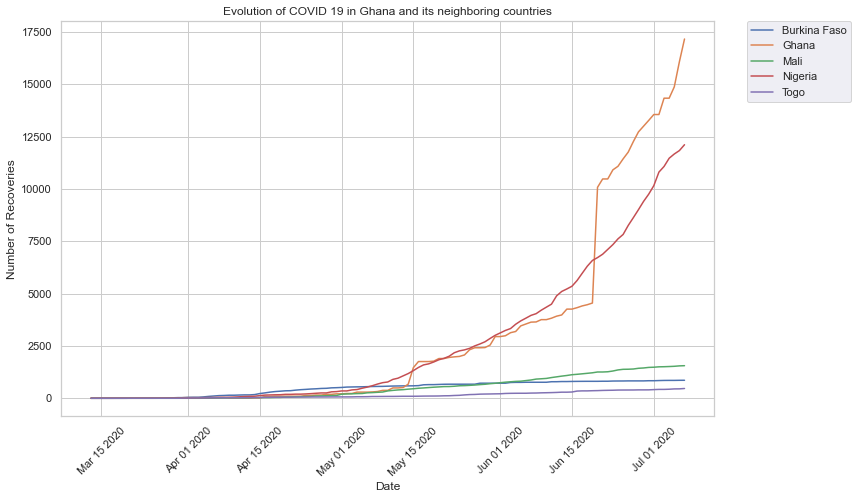

In [32]:
#Recovered Cases
for key, data in datagroup:
    with sns.axes_style('whitegrid'):
        chart6 = sns.lineplot(x=data['date'], y=data['recovered'], label=key)
        
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    chart6.set_xticklabels(data['date'],rotation=45)
    chart6.xaxis.set_major_formatter(mdates.DateFormatter('%b %d %Y'))
    chart6.set_title('Evolution of COVID 19 in Ghana and its neighboring countries')
    chart6.set(xlabel='Date', ylabel='Number of Recoveries')

## Twitter Link

https://twitter.com/augustine_virgo/status/1279894586240962565?s=20